In [65]:
import pickle
path = 'dataset/pickle/v2/greedy(test_angle)/5ZKStnWn8Zo/1066605.pkl'

In [66]:
with open(path , 'rb') as f:
    data = pickle.load(f)

In [3]:
data.keys(
)

dict_keys(['obs', 'reward', 'done', 'action_id', 'info', 'map', 'path_point', 'sound_id'])

In [89]:
data['obs'][0].keys()

dict_keys(['rgb', 'depth', 'spectrogram', 'category', 'pose', 'pose_gd', 'angle'])

In [91]:
from utils.angle import turn_angle

In [93]:
turn_angle(data['obs'][0]['pose'], data['path_point'][0][-1])

-3.38662651393257

In [14]:
data['info'][-1]

{'distance_to_goal': 0.0,
 'normalized_distance_to_goal': 0.0,
 'success': 1.0,
 'spl': 0.6666648476261747,
 'softspl': 0.6666648476261747,
 'na': 16,
 'sna': 1.0,
 'sws': 0.0,
 'top_down_map': {'map': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'fog_of_war_mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'agent_map_coord': (295, 183),
  'agent_angle': 6.283185307179586}}

In [6]:
data['obs'][0].keys()

dict_keys(['rgb', 'depth', 'spectrogram', 'category', 'pose', 'pose_gd', 'angle'])

In [17]:
data['obs'][0]['angle']

array([6.708204 , 2.6779451], dtype=float32)

In [10]:
data['sound_id']

['val/sofa/136493.wav']

In [19]:
data['reward']

[-0.01,
 0.99,
 0.99,
 -0.01,
 0.99,
 -0.01,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 -0.01,
 -0.01,
 0.99,
 9.99]

In [96]:
data['obs'][2]['category']

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [97]:
data['obs'][0].keys()

dict_keys(['rgb', 'depth', 'spectrogram', 'category', 'pose', 'pose_gd'])

In [109]:
len(data['reward'])

32

In [14]:
data['obs'][2]['spectrogram'][0].shape

(65, 126, 4)

In [4]:
from PIL import Image
import numpy as np
from utils.visualizations import plot_top_down_map

In [50]:
data['info'][-1]

{'distance_to_goal': 0.0,
 'normalized_distance_to_goal': 0.0,
 'success': 1.0,
 'spl': 0.6666648476261747,
 'softspl': 0.6666648476261747,
 'na': 16,
 'sna': 1.0,
 'sws': 0.0,
 'top_down_map': {'map': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'fog_of_war_mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'agent_map_coord': (295, 183),
  'agent_angle': 6.283185307179586}}

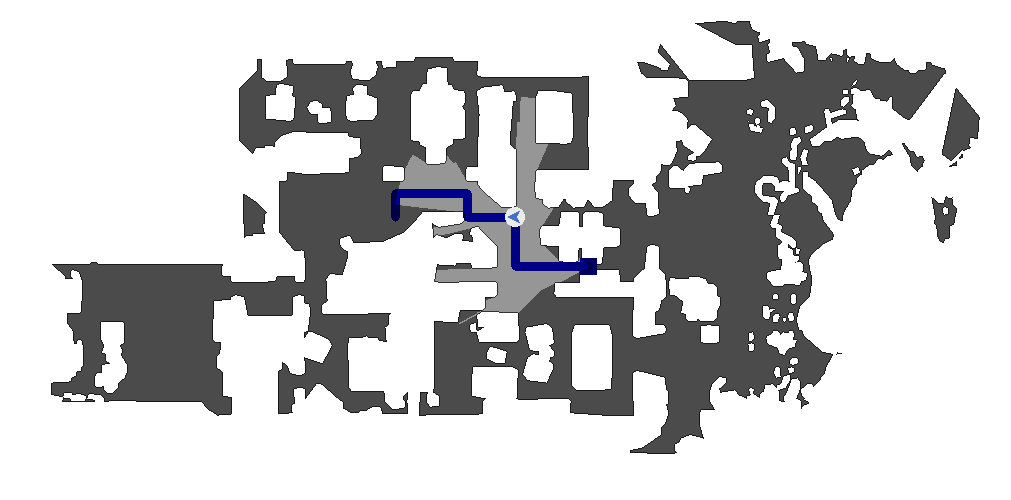

In [84]:
top_down_map = plot_top_down_map(data['info'][6])
Image.fromarray(top_down_map)

In [106]:
np.degrees(data['obs'][7]['angle'][1])

-0.0

In [107]:
turn_angle(data['obs'][7]['pose'], data['path_point'][0][-1])

-55.83651906290323

In [32]:
data['info'][3]

{'distance_to_goal': 4.0,
 'normalized_distance_to_goal': 0.4444444444444444,
 'success': 0.0,
 'spl': 0.0,
 'softspl': 0.33333333333333337,
 'na': 4,
 'sna': 0.0,
 'sws': 0.0,
 'top_down_map': {'map': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'fog_of_war_mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'agent_map_coord': (234, 208),
  'agent_angle': 6.283185307179586}}

In [36]:
data['action_id']

[[2, 1, 2, 1, 1, 1, 3, 1, 2, 1, 3, 1, 1, 3, 1, 2, 1, 3, 1, 2, 1, 0]]

In [37]:
len(data['reward'])

22

In [38]:
data['info']

[{'distance_to_goal': 10.0,
  'normalized_distance_to_goal': 0.8333333333333334,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.0,
  'na': 1,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 9.0,
  'normalized_distance_to_goal': 0.75,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.09999999999999998,
  'na': 2,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 9.0,
  'normalized_distance_to_goal': 0.75,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.09999999999999998,
  'na': 3,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 8.0,
  'normalized_distance_to_goal': 0.6666666666666666,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.19999999999999996,
  'na': 4,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 7.0,
  'normalized_distance_to_goal': 0.5833333333333334,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.30000000000000004,
  'na': 5,
  'sna': 0.0,
  'sws': 0.0},
 {'distance_to_goal': 6.0,
  'normalized_distance_to_goal': 0.5,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.4